In [ ]:
import math
import torch
import random
import tarfile
import torchtext
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
SEED = 12345
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
with tarfile.open("/content/drive/MyDrive/MT/training.tar.gz", "r") as tf:
    print("Opened tarfile")
    tf.extractall(path="/content")
    print("All files extracted")

Opened tarfile
All files extracted


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
en_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
de_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')

In [ ]:
def de_tokenizer(sentence):
  return de_tok_model(sentence)

def en_tokenizer(sentence):
  return en_tok_model(sentence)

In [ ]:
class Data():
  def __init__(self, en_filename, de_filename):
    self.en_file = open(en_filename, mode='rt', encoding='utf-8')
    self.en_text = self.en_file.read()
    self.en_file.close()
    self.de_file = open(de_filename, mode='rt', encoding='utf-8')
    self.de_text = self.de_file.read()
    self.de_file.close()
    self.en_text = self.en_text.strip().split('\n')
    self.de_text = self.de_text.strip().split('\n')
  def data(self):
    return self.en_text, self.de_text

In [ ]:
class Vocab():
  def __init__(self, en_filename, de_filename):
    self.en_len = 0
    self.de_len = 0
    self.en_count = Counter()
    self.de_count = Counter()
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    for idx in range(len(self.en_data)):
      self.en_sent = self.en_data[idx]
      self.de_sent = self.de_data[idx]
      self.en_sent = ['<SOS>'] + en_tokenizer(self.en_sent.lower().strip()) + ['<EOS>']
      self.de_sent = ['<SOS>'] + de_tokenizer(self.de_sent.lower().strip()) + ['<EOS>']
      if(len(self.en_sent) > self.en_len):
        self.en_len = len(self.en_sent)
      if(len(self.de_sent) > self.de_len):
        self.de_len = len(self.de_sent)
      self.en_count.update(self.en_sent)
      self.de_count.update(self.de_sent)
    self.en_vocab = set()
    for k,c in self.en_count.items():
      if len(self.en_vocab)<8190 :
        self.en_vocab.add(k)
    self.en_vocab.add('<PAD>')
    self.de_vocab = set()
    for k,c in self.de_count.items():
      if len(self.de_vocab)<8190 :
        self.de_vocab.add(k)
    self.de_vocab.add('<PAD>')
  def vocab(self):
    return self.en_vocab, self.de_vocab, self.en_len, self.de_len

In [ ]:
class Multi30K(Dataset):
  def __init__(self, en_filename, de_filename):
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    self.en_vocab, self.de_vocab, self.en_len, self.de_len = Vocab(en_filename, de_filename).vocab()
    self.en_word2idx = {w: idx for (idx, w) in enumerate(self.en_vocab)}
    self.en_word2idx.update({'<UNK>' : len(self.en_word2idx)})
    self.en_idx2word = {idx: w for (idx, w) in enumerate(self.en_vocab)}
    self.en_idx2word.update({len(self.en_idx2word) : '<UNK>'})
    self.de_word2idx = {w: idx for (idx, w) in enumerate(self.de_vocab)}
    self.de_word2idx.update({'<UNK>' : len(self.de_word2idx)})
    self.de_idx2word = {idx: w for (idx, w) in enumerate(self.de_vocab)}
    self.de_idx2word.update({len(self.de_idx2word) : '<UNK>'})

  def __len__(self):
    return len(self.en_data)

  def __getitem__(self, index):
    en_sent = self.en_data[index]
    de_sent = self.de_data[index]
    en_sent = ['<SOS>'] + en_tokenizer(en_sent.lower().strip()) + ['<EOS>']
    de_sent = ['<SOS>'] + de_tokenizer(de_sent.lower().strip()) + ['<EOS>']
    for i in range(len(en_sent)):
      if en_sent[i] in self.en_vocab:
        en_sent[i] = self.en_word2idx[en_sent[i]]
      else:
        en_sent[i] = self.en_word2idx['<UNK>']
    for i in range(len(de_sent)):
      if de_sent[i] in self.de_vocab:
        de_sent[i] = self.de_word2idx[de_sent[i]]
      else:
        de_sent[i] = self.de_word2idx['<UNK>']
    for i in range(len(en_sent), self.en_len):
      en_sent.append(self.en_word2idx['<PAD>'])
    for i in range(len(de_sent), self.de_len):
      de_sent.append(self.de_word2idx['<PAD>'])
    en_sent = torch.tensor(en_sent)
    de_sent = torch.tensor(de_sent)
    return en_sent, de_sent

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self,  embedding_dim, hidden_size, vocab_size, num_layers):
    super(EncoderRNN, self).__init__()
    self.embedd = nn.Embedding(vocab_size, embedding_dim)
    self.encoder_rnn = nn.LSTM(embedding_dim, hidden_size, num_layers)

  def forward(self, en_sent):
    embeddings = self.embedd(en_sent)
    out, states = self.encoder_rnn(embeddings)
    return states

class DecoderRNN(nn.Module):
  def __init__(self,  embedding_dim, hidden_size, vocab_size, num_layers):
    super(DecoderRNN, self).__init__()
    self.embedd = nn.Embedding(vocab_size, embedding_dim)
    self.decoder_rnn = nn.LSTM(embedding_dim, hidden_size, num_layers)
    self.L1 = nn.Linear(hidden_size, vocab_size)

  def forward(self, fr_sent, states):
    embeddings = self.embedd(fr_sent)
    out, states = self.decoder_rnn(embeddings, states)
    out = self.L1(out)
    return out, states

class Model(nn.Module):
  def __init__(self, embedding_dim, hidden_size, en_vocab_size, de_vocab_size, num_layers):
    super(Model, self).__init__()
    self.Encoder = EncoderRNN(embedding_dim, hidden_size, en_vocab_size, num_layers)
    self.Decoder = DecoderRNN(embedding_dim, hidden_size, de_vocab_size, num_layers)
    self.de_vocab_size = de_vocab_size

  def forward(self, en_sent, de_sent):
    enc_states = self.Encoder(en_sent)
    dec_states = enc_states
    seq_len = de_sent.shape[0]
    batch_size = de_sent.shape[1]
    predictions = torch.zeros(seq_len, batch_size, self.de_vocab_size).to(device)
    inp = de_sent[0,:].unsqueeze(0)
    for t in range(1, seq_len):
      output, dec_states = self.Decoder(inp, dec_states)
      output = output.squeeze()
      predictions[t] = output.view(batch_size, self.de_vocab_size)
      inp = output.argmax(1).unsqueeze(0)

    return predictions

In [ ]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}

In [ ]:
dataset = Multi30K('/content/train.en', '/content/train.de')
data = DataLoader(dataset, **params)

In [ ]:
embedding_dim = 512
hidden_size = 512
en_vocab_size = len(dataset.en_vocab)
de_vocab_size = len(dataset.de_vocab)
num_layers = 2

In [ ]:
model = Model(embedding_dim, hidden_size, en_vocab_size+1, de_vocab_size+1, num_layers)
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.de_word2idx["<PAD>"])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_loss, train_perplexity = [], []
valid_loss, valid_perplexity = [], []
for epoch in range(10):
  epoch_loss = 0
  for t, (en,de) in enumerate(data):
    if t < 906:
      en = en.mT.to(device)
      de = de.mT.to(device)
      out = model(en, de)
      loss = criterion(out.reshape(-1, out.shape[2]), de.reshape(-1))
      epoch_loss += float(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      en = en.mT.to(device)
      de = de.mT.to(device)
      out = model(en, de)
      loss = criterion(out.reshape(-1, out.shape[2]), de.reshape(-1))
      out = torch.argmax(out, dim=2)

  valid_loss.append(float(loss))
  train_loss.append(epoch_loss/len(data))
  valid_perplexity.append(float(torch.exp(loss)))
  train_perplexity.append(math.exp(epoch_loss/len(data)))
  print("-"*25, f"Epoch {epoch + 1}","-"*25)
  print("Train Loss : ", round(train_loss[-1],3), "Train Perplexity : ", round(train_perplexity[-1],3))
  print("Valid Loss : ", round(valid_loss[-1],3), "Valid Perplexity : ", round(valid_perplexity[-1],3))

------------------------- Epoch 1 -------------------------
Train Loss :  5.045 Train Perplexity :  155.202
Valid Loss :  4.669 Valid Perplexity :  106.609
------------------------- Epoch 2 -------------------------
Train Loss :  4.432 Train Perplexity :  84.118
Valid Loss :  4.618 Valid Perplexity :  101.324
------------------------- Epoch 3 -------------------------
Train Loss :  4.114 Train Perplexity :  61.183
Valid Loss :  3.524 Valid Perplexity :  33.918
------------------------- Epoch 4 -------------------------
Train Loss :  3.852 Train Perplexity :  47.066
Valid Loss :  3.755 Valid Perplexity :  42.717
------------------------- Epoch 5 -------------------------
Train Loss :  3.62 Train Perplexity :  37.343
Valid Loss :  3.424 Valid Perplexity :  30.689
------------------------- Epoch 6 -------------------------
Train Loss :  3.411 Train Perplexity :  30.296
Valid Loss :  3.979 Valid Perplexity :  53.477
------------------------- Epoch 7 -------------------------
Train Loss :  

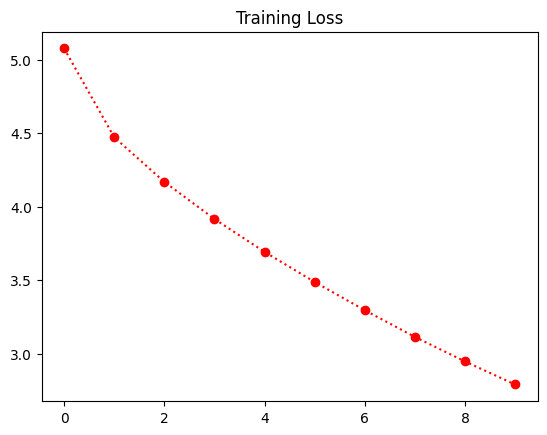

In [ ]:
plt.plot(train_loss, 'o:r')
plt.title("Training Loss")
plt.show()

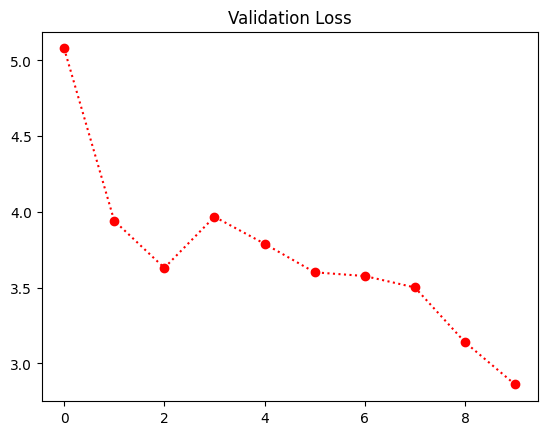

In [ ]:
plt.plot(valid_loss, 'o:r')
plt.title("Validation Loss")
plt.show()

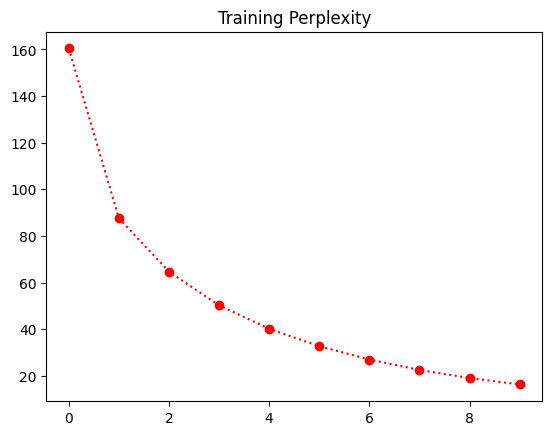

In [ ]:
plt.plot(train_perplexity, 'o:r')
plt.title("Training Perplexity")
plt.show()

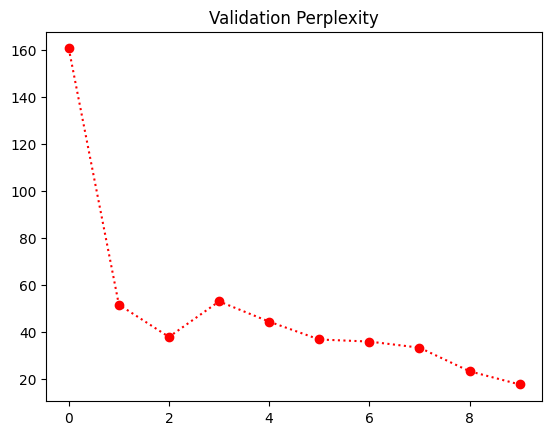

In [ ]:
plt.plot(valid_perplexity, 'o:r')
plt.title("Validation Perplexity")
plt.show()

In [ ]:
def Translate(src_sentence,  model):
  with torch.no_grad():
    enc_states = model.Encoder(src_sentence)
  dec_states = enc_states
  sos_id = dataset.de_word2idx['<SOS>']
  eos_id = dataset.de_word2idx['<EOS>']
  predicts = [sos_id]
  len = 1
  max_len = 40
  while len < max_len:
    inp = torch.LongTensor([predicts[-1]]).view((1, 1)).to(device)
    with torch.no_grad():
      outputs, dec_states = model.Decoder(inp, dec_states)
    outputs = outputs.squeeze()
    outputs = outputs.view(-1, 8192)
    predicts.append(outputs.argmax(-1).item())
    len += 1
    if predicts[-1] == eos_id:
      break
  sentence = [dataset.de_idx2word[id] for id in predicts]
  return sentence

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def CalcBELU(model, dataset):
  belu_score = 0
  for n in range(1,9):
    true_translation = []
    (en,de) = dataset[-n]
    en = en.resize_(en.size(0),1).to(device)
    pred_translation = Translate(en, model)
    for id in de:
      if id != dataset.de_word2idx['<PAD>']:
        true_translation.append(dataset.de_idx2word[int(id)])
    belu_score += float(sentence_bleu([pred_translation], true_translation))
  return belu_score/8

In [ ]:
print("Obtained BELU Score : ", CalcBELU(model, dataset)*100)

Obtained BELU Score :  28.446705281295404


In [ ]:
txt = input("Enter A Text : ")
txt = en_tokenizer(txt.lower().strip())
for i in range(len(txt)):
  if txt[i] in dataset.en_vocab:
    txt[i] = dataset.en_word2idx[txt[i]]
  else:
    txt[i] = dataset.en_word2idx['<UNK>']
txt = torch.tensor(txt)
txt.resize_(len(txt), 1)
txt = txt.to(device)
german = Translate(txt, model)
print(german)

Enter A Text : A man in a white shirt
['<SOS>', 'ein', 'mann', 'mit', 'einem', 'weißen', 'hemd', 'in', '<EOS>']
